## Importando as bibliotecas

In [35]:
import seaborn as sns; sns.set_theme()
import ControlledWattsGraph as cwg
import GeosocialAlgorithms as ga
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import json
import utm
import csv

from sklearn.metrics.cluster import adjusted_mutual_info_score as ami
from matplotlib.colors import LogNorm
from tqdm import tqdm as tqdmBasic

In [36]:
# Definindo número de vértices do grafo
NUMBER_OF_VERTICES = 3000

# Latitudes e longitudes máximas e mínimas
LAT_MIN = 36.9609718322753338
LAT_MAX = 42.1543159484863281
LON_MIN = -9.5470819473266033
LON_MAX = -6.1891422271728516

### Métodos gerais

In [37]:
def calculate_distance_geographic(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the distance between two points in the geographic space.
    
    Args:
        lat1 (float): Latitude of the first point.
        lon1 (float): Longitude of the first point.
        lat2 (float): Latitude of the second point.
        lon2 (float): Longitude of the second point.
        
    Returns:
        float: The distance between the two points.
        
    Example:
        >>> calculate_distance_geographic(37.7749, -122.4194, 34.0522, -118.2437)
        559.23
    """
    x1, y1, _, _ = utm.from_latlon(lat1, lon1)
    x2, y2, _, _ = utm.from_latlon(lat2, lon2)

    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [38]:
def calculate_distance(xP1: float, yP1: float, xP2: float, yP2: float) -> float:
    """
    Calculate the distance between two points in the Euclidean space.
    
    Args:
        xP1 (float): X-coordinate of the first point.
        yP1 (float): Y-coordinate of the first point.
        xP2 (float): X-coordinate of the second point.
        yP2 (float): Y-coordinate of the second point.
        
    Returns:
        float: The distance between the two points.
        
    Example:
        >>> calculate_distance(0, 0, 3, 4)
        5.0
    """
    P1 = [xP1, yP1]
    P2 = [xP2, yP2]
    
    return math.dist(P1, P2)

In [39]:
def generate_colors(n: int) -> np.ndarray:
    """
    Generate a list of colors for plotting.
    
    Args:
        n (int): Number of colors to generate.
        
    Returns:
        np.ndarray: A list of colors.
        
    Example:
        >>> generate_colors(5)
        array([[1.        , 0.        , 0.        , 1.        ],
               [1.        , 0.5       , 0.        , 1.        ],
               [1.        , 1.        , 0.        , 1.        ],
               [0.5       , 1.        , 0.        , 1.        ],
               [0.        , 1.        , 0.        , 1.        ]])
    """
    cmap = plt.colormaps['hsv']
    colors = cmap(np.linspace(0, 1, n+1))
    return colors

In [40]:
def convert_geo_to_utm(graph: nx.graph, column_lat: str = 'median_lat', column_lon: str = 'median_lon') -> nx.graph:
    """
    Convert the geographic coordinates of the nodes in the graph to UTM coordinates.

    Args:
        graph (nx.graph): A graph object.
        column_lat (str, optional): Column name of the latitude component. Defaults to 'median_lat'.
        column_lon (str, optional): Column name of the longitude component. Defaults to 'median_lon'.

    Returns:
        nx.graph: A graph object with UTM coordinates.
        
    Example:
        >>> G = nx.Graph()
        >>> G.add_node(1, median_lat=37.7749, median_lon=-122.4194)
        >>> G.add_node(2, median_lat=34.0522, median_lon=-118.2437)
        >>> convert_geo_to_utm(G)
        >>> print(G.nodes[1]['median_X'], G.nodes[1]['median_Y'])
        551730.0 4182689.0                
    """
    for node in graph.nodes():
        latitute = float(graph.nodes[node][column_lat])
        longitude = float(graph.nodes[node][column_lon])
        
        easting, northing, _, _ = utm.from_latlon(latitute, longitude)
        graph.nodes[node]['median_X'] = easting
        graph.nodes[node]['median_Y'] = northing
        
    return graph

### Métodos de cálculo com a rede

In [41]:
def show_graph_metrics(graph: nx.graph) -> None:
    """
    Show some metrics of the graph.
    
    Args:
        graph (nx.graph): A graph object.
        
    Example:
        >>> G = nx.Graph()
        >>> G.add_node(1)
        >>> G.add_node(2)
        >>> G.add_edge(1, 2)
        >>> show_graph_metrics(G)
        Nº de nós: 2
        Nº de links: 1
        Grau médio: 1.0
        Densidade: 1.0
    """    
    degrees = []

    for node in graph.nodes():
        degrees.append(nx.degree(graph, node))
        
    print(f"Nº de nós: {graph.number_of_nodes()}")
    print(f"Nº de links: {graph.number_of_edges()}")
    print(f"Grau médio: {np.mean(degrees)}")
    print(f"Densidade: {nx.density(graph)}")
    # print(f"Cluster global: {nx.transitivity(graph)}")
    # print(f"Cluster médio: {nx.average_clustering(graph)}")

In [42]:
def return_graph_metrics(graph: nx.graph) -> dict:
    """
    Return some metrics of the graph.

    Args:
        graph (nx.graph): A graph object.

    Returns:
        dict: A dictionary with the metrics.
        
    Example:
        >>> G = nx.Graph()
        >>> G.add_node(1)
        >>> G.add_node(2)
        >>> G.add_edge(1, 2)
        >>> return_graph_metrics(G)
        {'numero_nos': 2, 'numero_links': 1, 'grau_medio': 1.0, 'densidade': 1.0}
    """
    degrees = []

    for node in graph.nodes():
        degrees.append(nx.degree(graph, node))
        
    return {
        "numero_nos": graph.number_of_nodes(),
        "numero_links": graph.number_of_edges(),
        "grau_medio": np.mean(degrees),
        "densidade": nx.density(graph)
    }

In [43]:
def merge_duplicate_nodes(graph: nx.Graph) -> tuple[nx.Graph, dict]:
    """Merge duplicate nodes in a graph.

    Args:
        graph (nx.Graph): Graph to be processed.

    Raises:
        KeyError: If the graph does not have a 'coords' attribute in the nodes.
        
    Returns:
        tuple: Tupla contendo:
            graph (nx.Graph): Graph with merged nodes.
            unique_coords (dict): Dictionary with the unique coordinates.
        
    Examples:
        >>> G = nx.Graph()
        >>> G.add_node(1, coords=(1, 2))
        >>> G.add_node(2, coords=(1, 2))
        >>> G.add_node(3, coords=(3, 4))
        
        >>> G.add_edge(1, 2)
        >>> G.add_edge(2, 3)
        
        >>> G, unique_coords = merge_duplicate_nodes(G)
        >>> print(unique_coords)
        {(1, 2): 1, (3, 4): 3}
    """
    
    unique_coords = {}

    for node in list(graph.nodes()):
        try:
            coords = graph.nodes[node]['coords']
        except KeyError:
            raise KeyError("The graph must have a 'coords' attribute in the nodes.")
        
        if coords in unique_coords:      
            graph.add_edges_from(graph.edges(node))        
            graph.remove_node(node)
        else:        
            unique_coords[coords] = node
            
    return graph, unique_coords

### Métodos de análise de comunidades

In [44]:
def map_community_nodes(community: list) -> dict:
    """Atribui um número de comunidade a cada nó de cada grafo.

    Args:
        community (list): Lista de comunidades do grafo 1.

    Returns:
        node_community_map (dict): Dicionário com o mapeamento dos nós para as comunidades.
        
    Examples:
        >>> community1 = [{1, 2, 3}, {4, 5, 6}]
        >>> map_community_nodes(community1)
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1}
    """
    node_community_map = {}

    for i, comm in enumerate(community):
        for node in comm:
            node_community_map[node] = i
            
    return node_community_map


In [45]:
def jaccard_similarity(community1: set, community2: set) -> float:
    """Calcula a similaridade de Jaccard entre duas comunidades.

    Args:
        community1 (set): Comunidade 1.
        community2 (set): Comunidade 2.

    Returns:
        float: O índice de similaridade de Jaccard.
        
    Examples:
        >>> community1 = {1, 2, 3}
        >>> community2 = {2, 3, 4}
        >>> jaccard_similarity(community1, community2)
        0.5
    """
    intersection = len(community1.intersection(community2))
    union = len(community1.union(community2))
    
    return intersection / union

In [46]:
def assign_labels(partition, all_elements):
    """Define os rótulos de cada elemento com base na partição.

    Args:
        partition (list): A partição.
        all_elements (list): Todos os elementos.
        
    Returns:
        list: Uma lista com os rótulos de cada elemento.
        
    Examples:
        >>> partition = [{1, 2, 3}, {4, 5, 6}]
        >>> all_elements = [1, 2, 3, 4, 5, 6]
        >>> assign_labels(partition, all_elements)
        [0, 0, 0, 1, 1, 1]
    """
    labels = {}
    for cluster_id, cluster in enumerate(partition):
        for element in cluster:
            labels[element] = cluster_id
    return [labels[element] for element in all_elements]

### Métodos de plotagem

In [47]:
def plotScatterEmpyricalComplementarDistribution(distances, output_path: str = 'E://', output_file_name: str = 'empyrical_complementar_distribution.png', show: bool = False, log: bool = False):
    """Plota o gráfico de dispersão da distribuição empírica complementar.

    Args:
        distances (list): Lista com as distâncias.
        output_path (str): Caminho de saída do arquivo.
        output_file_name (str): Nome do arquivo de saída.
        show (bool): Se o gráfico deve ser exibido.                
    """    
    # sort the distances

    # calculate the probability of each distance
    if isinstance(distances, dict):
        keys_in_order = sorted(distances.keys())
        length_distances = sum(distances.values())
        dist = 1
        prob = []
        print(f"keys_in_order: {keys_in_order}")
        print(f"length_distances: {length_distances}")
        
        distances_list = [key for key, value in distances.items() for _ in tqdmBasic(range(value))]
        n = len(distances_list)
        prob = [1 - (i+1)/n for i in tqdmBasic(range(0,n))]
                    
        distances = list(distances.keys())
        
    else:
        distances.sort()
        if log == True:
            prob = [np.log10(1 - (i/len(distances))) for i in tqdmBasic(range(len(distances)), desc="Calculando probabilidade")]
        else:
            prob = [1 - (i/len(distances)) for i in tqdmBasic(range(len(distances)))]
            
    print(type(prob))

    # plot the scatter graph
    plt.figure(figsize=(180, 120))
    plt.scatter(distances, prob)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Distância")
    plt.ylabel("Probabilidade")
    plt.savefig(f"{output_path}{output_file_name}", dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()
       

In [48]:
def plot_colored_communities(grafo: nx.Graph, grafo_geo: nx.Graph, communities_social: list, communities_geo: list, 
                             latitude: str = 'lat', longitude: str = 'long', with_labels: bool = False, use_geolocation: bool = True):
    """
    Plot the graph with colored nodes based on communities.

    Args:
        grafo (nx.Graph): A graph object.
        grafo_geo (nx.Graph): A graph object with geographic coordinates.
        communities_social (list): A list of communities of the social graph.
        communities_geo (list): A list of communities of the geographic graph.
        latitude (str, optional): Column name of the latitude component. Defaults to 'lat'.
        longitude (str, optional): Column name of the longitude component. Defaults to 'long'.
        with_labels (bool, optional): If the labels should be displayed. Defaults to False.
        use_geolocation (bool, optional): If the geographic coordinates should be used. Defaults to True.
    """
    if use_geolocation:
        pos = {node: (grafo.nodes[node][latitude], grafo.nodes[node][longitude]) for node in grafo.nodes()}
    else:
        pos = nx.spring_layout(grafo)
        
    pos_geo = {node: (grafo_geo.nodes[node][latitude], grafo_geo.nodes[node][longitude]) for node in grafo_geo.nodes()}
    
    colors_original = generate_colors(len(communities_social))
    colors_geo = generate_colors(len(communities_geo))
    
    node_colors_original = {}
    node_colors_geo = {}
    
    for i, com in enumerate(communities_social):
        for node in com:
            node_colors_original[node] = colors_original[i]
            
    for i, com in enumerate(communities_geo):
        for node in com:
            node_colors_geo[node] = colors_geo[i]    

    # Plot the graph with colored nodes based on communities
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.subplot(1, 2, 1)
    nx.draw_networkx(grafo, pos=pos, node_color=[node_colors_original[node] for node in grafo.nodes()], node_size=100, font_size=10, with_labels=with_labels)
    plt.axis('on')
    plt.title("Comunidades do grafo social")

    plt.subplot(1, 2, 2)
    nx.draw_networkx(grafo_geo, pos=pos_geo, node_color=[node_colors_geo[node] for node in grafo_geo.nodes()], node_size=100, font_size=10, with_labels=with_labels)
    plt.axis('on')
    plt.title("Comunidades do grafo geográfico")

    plt.show()

### Métodos de exportação de arquivos

In [49]:
def _export_dictionary(dict : dict, path : str = 'E://', file_name : str = 'dict.json'):
    """Exporta um dicionário para um arquivo JSON

    Args:
        dict (dict): dicionário a ser exportado
        path (str, optional): Caminho do arquivo de saída. Defaults to 'E:/'.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'dict.json'.
    """                
    with open(f"{path}{file_name}", 'w') as f:
        json.dump(dict, f)

In [50]:
def _export_list_to_csv(list : list, path : str = 'E://', file_name : str = 'list.csv'):
    """Exporta uma lista para um arquivo CSV

    Args:
        list (list): Lista a ser exportada
        path (str, optional): Caminho do arquivo de saída. Defaults to 'E:/'.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'list.csv'.
    """                
    with open(f"{path}{file_name}", 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(list)

In [51]:
def _export_graphml(graph : nx.Graph, path : str = 'E://', file_name : str = 'graph.graphml'):
    """Exporta um grafo para um arquivo GraphML

    Args:
        graph (nx.Graph): Grafo a ser exportado
        path (str, optional): Caminho do arquivo de saída. Defaults to 'E:/'.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'graph.graphml'.
    """
    
    # remove the 'coords' attribute from the nodes
    
    for node in graph.nodes():
        if 'coords' in graph.nodes[node]:
            del graph.nodes[node]['coords']
        if 'pos' in graph.nodes[node]:
            del graph.nodes[node]['pos']
    
    nx.write_graphml(graph, f"{path}{file_name}")

### Modelo Watts–Strogatz

In [52]:
k = 30
controle_grafo = cwg.ControlledWattsGraph(NUMBER_OF_VERTICES, k)
grafo = controle_grafo.graph

In [53]:
controle_grafo.randomize_edges(200)
grafo = controle_grafo.graph

In [54]:
len(controle_grafo.original_edges)

44800

In [55]:
show_graph_metrics(grafo)

Nº de nós: 3000
Nº de links: 45000
Grau médio: 30.0
Densidade: 0.010003334444814937


In [56]:
# Define the radius and the angle increment
radius = 150
angle_increment = 2 * np.pi / NUMBER_OF_VERTICES

# Assign x and y coordinates to each node
for i, node in enumerate(grafo.nodes()):
    angle = i * angle_increment
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    grafo.nodes[node]['x'] = x
    grafo.nodes[node]['y'] = y
    grafo.nodes[node]['coords'] = (x, y)

In [57]:
# Define colors for edges
edge_colors = []
original_edges_set = set(controle_grafo.original_edges)

for edge in grafo.edges():
    if edge in original_edges_set or (edge[1], edge[0]) in original_edges_set:
        edge_colors.append('blue')  # Color for original edges
    else:
        edge_colors.append('red')  # Color for new edges

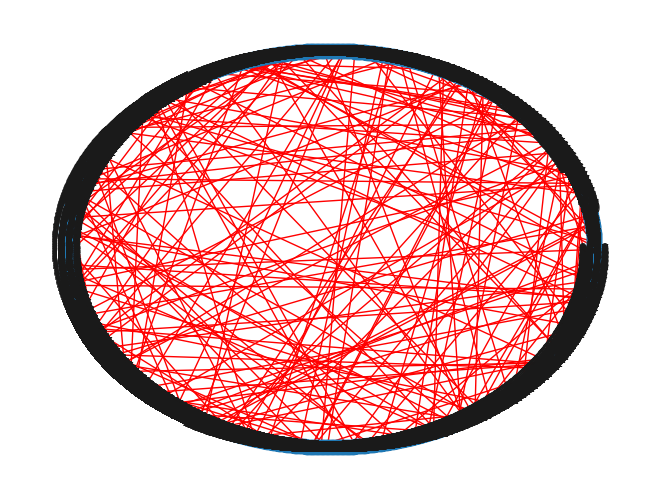

In [58]:
nx.draw(grafo, pos=nx.get_node_attributes(grafo, 'coords'), edge_color=edge_colors, with_labels=True, node_size=100, font_size=10)

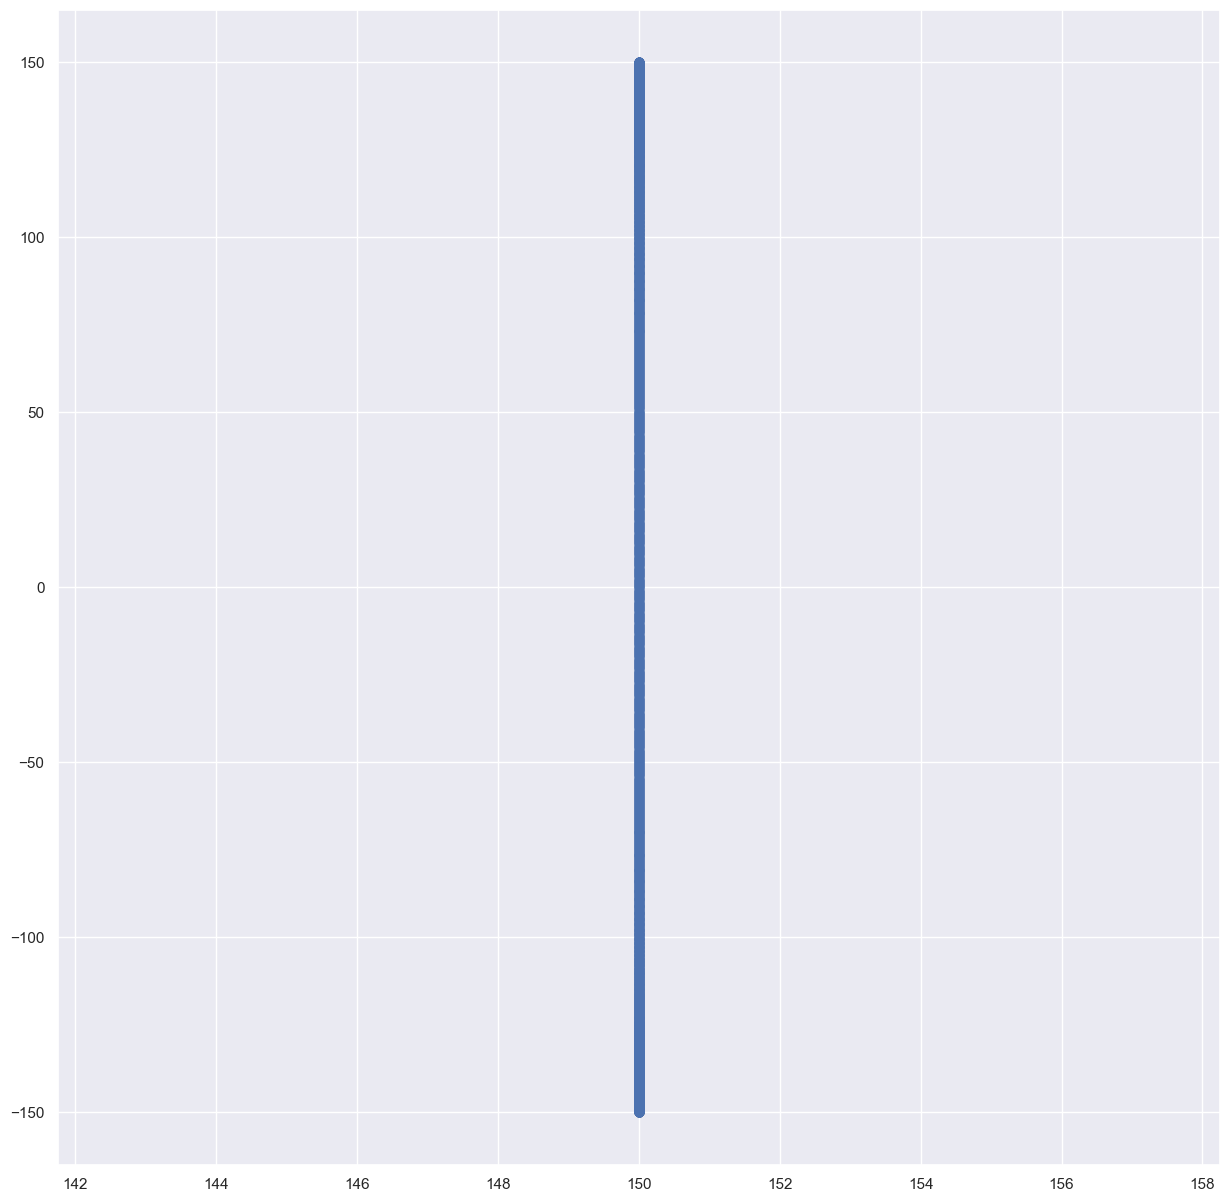

In [59]:
# plot the graph in x-y coordinates

plt.figure(figsize=(15, 15))
plt.scatter([grafo.nodes[node]['x'] for nod in grafo.nodes()], [grafo.nodes[node]['y'] for node in grafo.nodes()])

plt.axis('on')
plt.show()


In [60]:
a = 1
b = 1
angulo = (360* (k+1) /2) /NUMBER_OF_VERTICES

c = math.sqrt(a**2 + b**2 - 2*a*b*math.cos(math.radians(angulo)))*radius

print(c)

4.86925479458717


In [61]:
geosocial = ga.GeoSocial(grafo, lat='y', lon='x')

grafo_geo = geosocial.return_geographic_graph_by_radius(c, coords_str='coords')

In [62]:
show_graph_metrics(grafo_geo)

Nº de nós: 3000
Nº de links: 45000
Grau médio: 30.0
Densidade: 0.010003334444814937


In [63]:
comunidade_social_watts = nx.community.greedy_modularity_communities(grafo)
comunidade_geo = nx.community.greedy_modularity_communities(grafo_geo)

In [64]:
nx.community.modularity(grafo, comunidade_social_watts)

0.5805475437037037

In [65]:
nx.community.modularity(grafo_geo, comunidade_geo)

0.551466

In [66]:
node_community_map_social = map_community_nodes(comunidade_social_watts)
node_community_map_geo = map_community_nodes(comunidade_geo)

for node in tqdmBasic(grafo.nodes()):
    grafo.nodes[node]['social_community'] = node_community_map_social[node]
    grafo.nodes[node]['geo_community'] = node_community_map_geo[node]

100%|██████████| 3000/3000 [00:00<00:00, 1000310.99it/s]


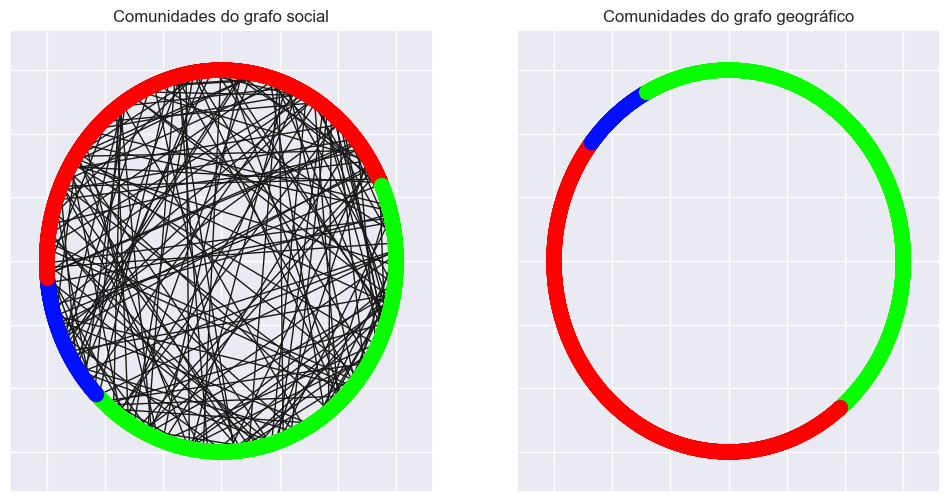

In [67]:
plot_colored_communities(grafo, grafo_geo, comunidade_social_watts, comunidade_geo, with_labels=False, latitude='y', longitude='x', use_geolocation=True)

In [34]:
nx.draw(grafo, pos=nx.spring_layout(grafo), node_color=[grafo.nodes[node]['social_community'] for node in grafo.nodes()], node_size=20, font_size=10, with_labels=False)

KeyboardInterrupt: 

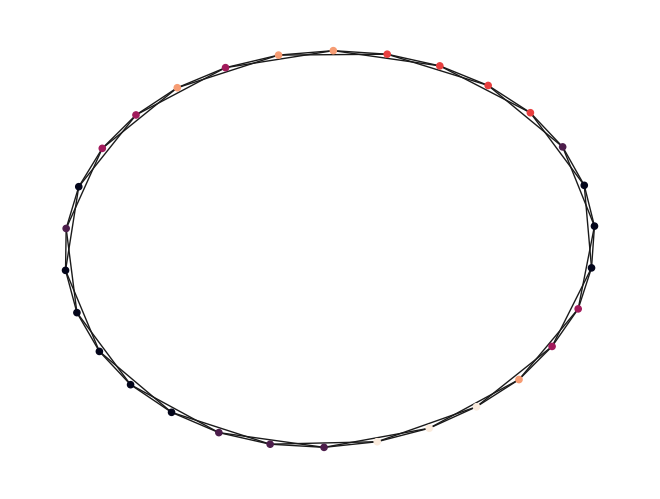

In [75]:
nx.draw(grafo_geo, pos=nx.spring_layout(grafo_geo), node_color=[grafo.nodes[node]['social_community'] for node in grafo_geo.nodes()], node_size=20, font_size=10, with_labels=False)

In [68]:
jaccard_matrix_watts = np.zeros((len(comunidade_social_watts), len(comunidade_geo)))

for i, com_social in enumerate(comunidade_social_watts):
    for j, com_geo in enumerate(comunidade_geo):
        jaccard_matrix_watts[i][j] = jaccard_similarity(set(com_social), set(com_geo))

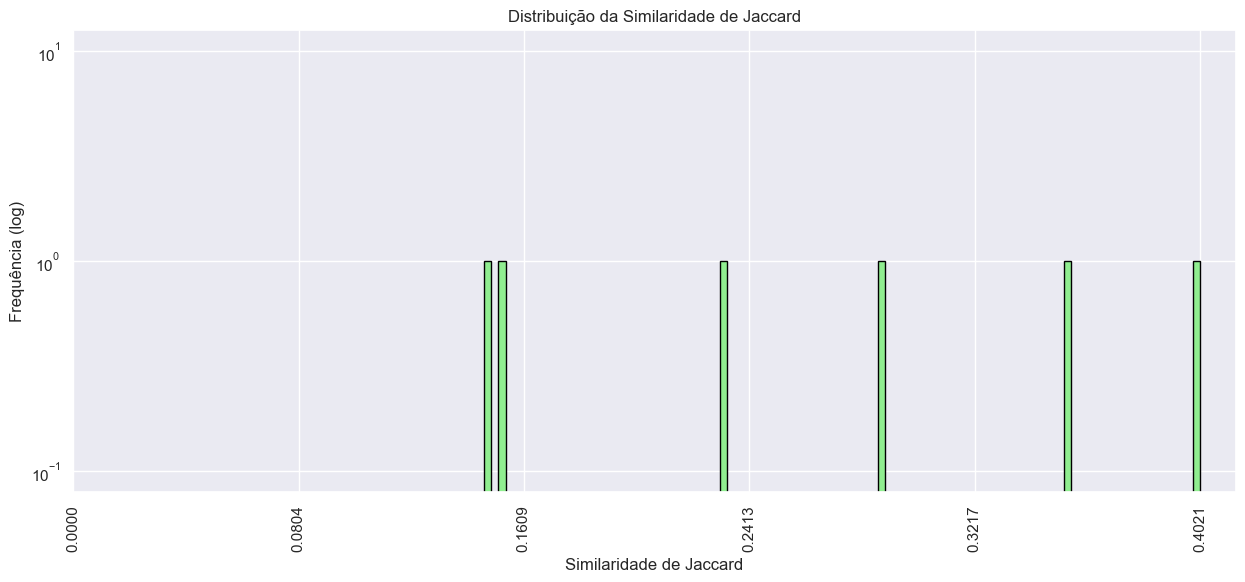

In [69]:
jaccard_values_watts = jaccard_matrix_watts[jaccard_matrix_watts !=0]
upper_limit_watts = np.max(jaccard_values_watts)*1.2
division_watts = np.max(jaccard_values_watts)/5

plt.figure(figsize=(15, 6))
plt.hist(jaccard_values_watts, bins=100, color='lightgreen', edgecolor='black', log=True)
plt.xlabel("Similaridade de Jaccard")
plt.xticks(np.arange(0, upper_limit_watts, division_watts), rotation=90)
plt.ylabel('Frequência (log)')
plt.title('Distribuição da Similaridade de Jaccard')
plt.show()

In [70]:
for line in jaccard_matrix_watts:
    sorted_line = np.sort(line)
    print(sorted_line)

[0.         0.05882353 0.125      0.5       ]
[0.         0.07692308 0.16666667 0.16666667]
[0.         0.07692308 0.16666667 0.33333333]
[0.         0.         0.         0.44444444]
[0.         0.08333333 0.16666667 0.18181818]
[0.         0.         0.         0.33333333]


In [71]:
jaccard_matrix_sorted = np.sort(jaccard_matrix_watts, axis=1)

In [70]:
from scipy.optimize import linear_sum_assignment

# Usando o algoritmo Hungarian para encontrar a melhor correspondência para a diagonal
cost_matrix = -jaccard_matrix_watts  # Inverter sinais para transformar em problema de maximização
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Reordenando as linhas e colunas para maximizar a diagonal
permuted_matrix = jaccard_matrix_watts[row_ind][:, col_ind]

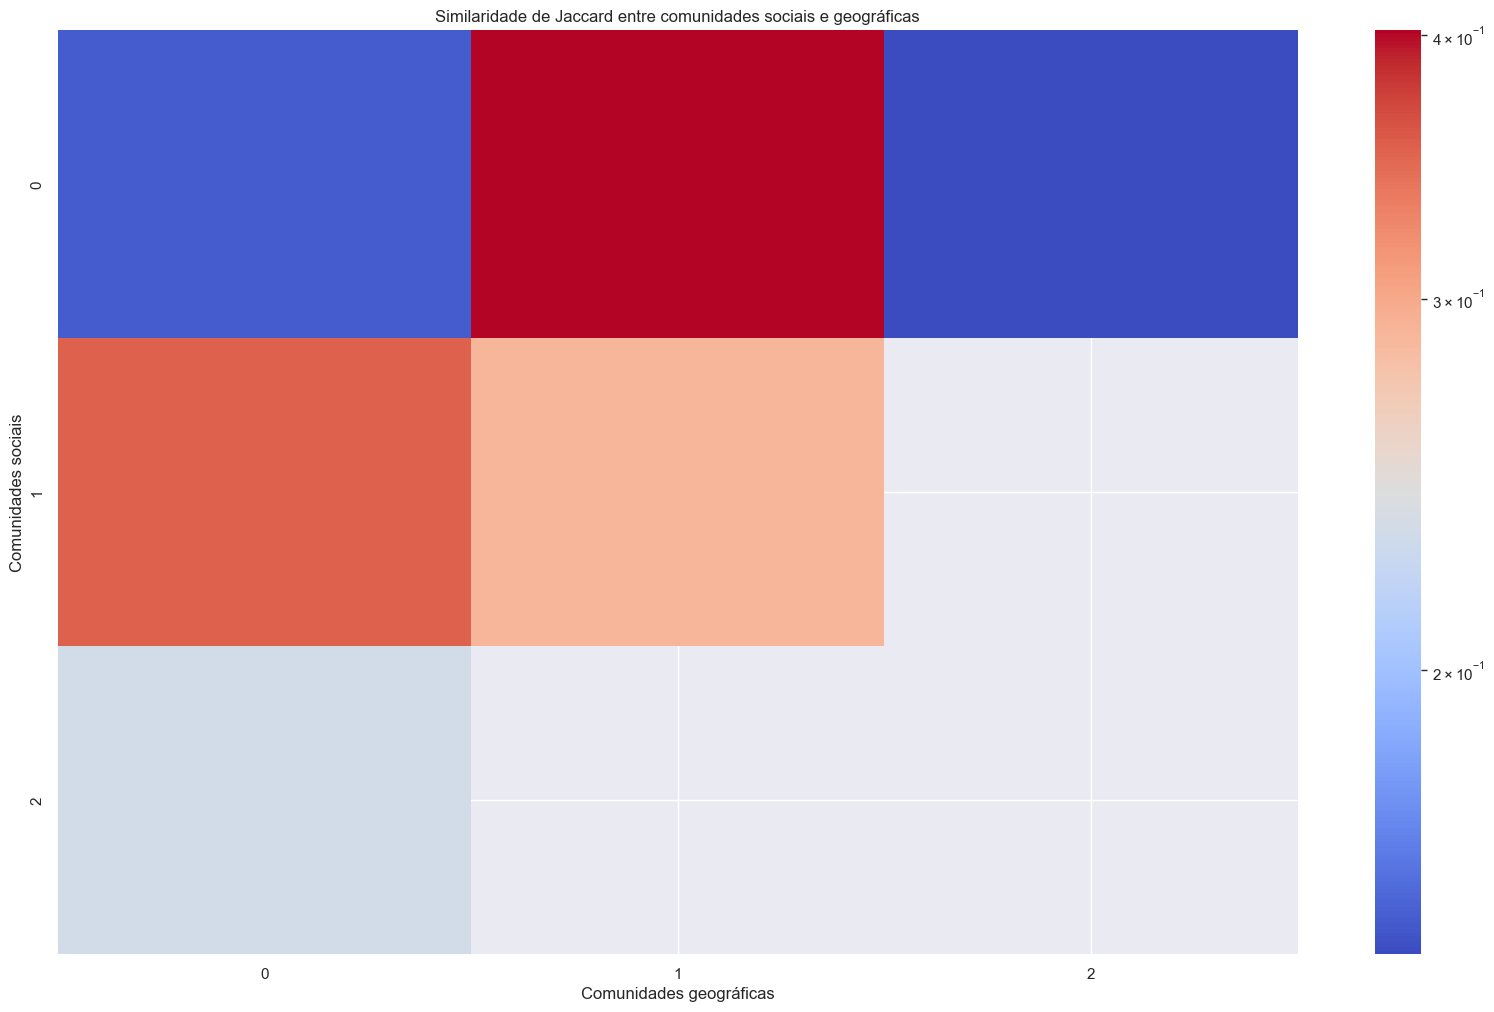

In [71]:
plt.figure(figsize=(20, 12))
sns.heatmap(jaccard_matrix_watts, cmap='coolwarm', norm=LogNorm())
plt.xlabel('Comunidades geográficas')
plt.ylabel('Comunidades sociais')
plt.title('Similaridade de Jaccard entre comunidades sociais e geográficas')
plt.show()

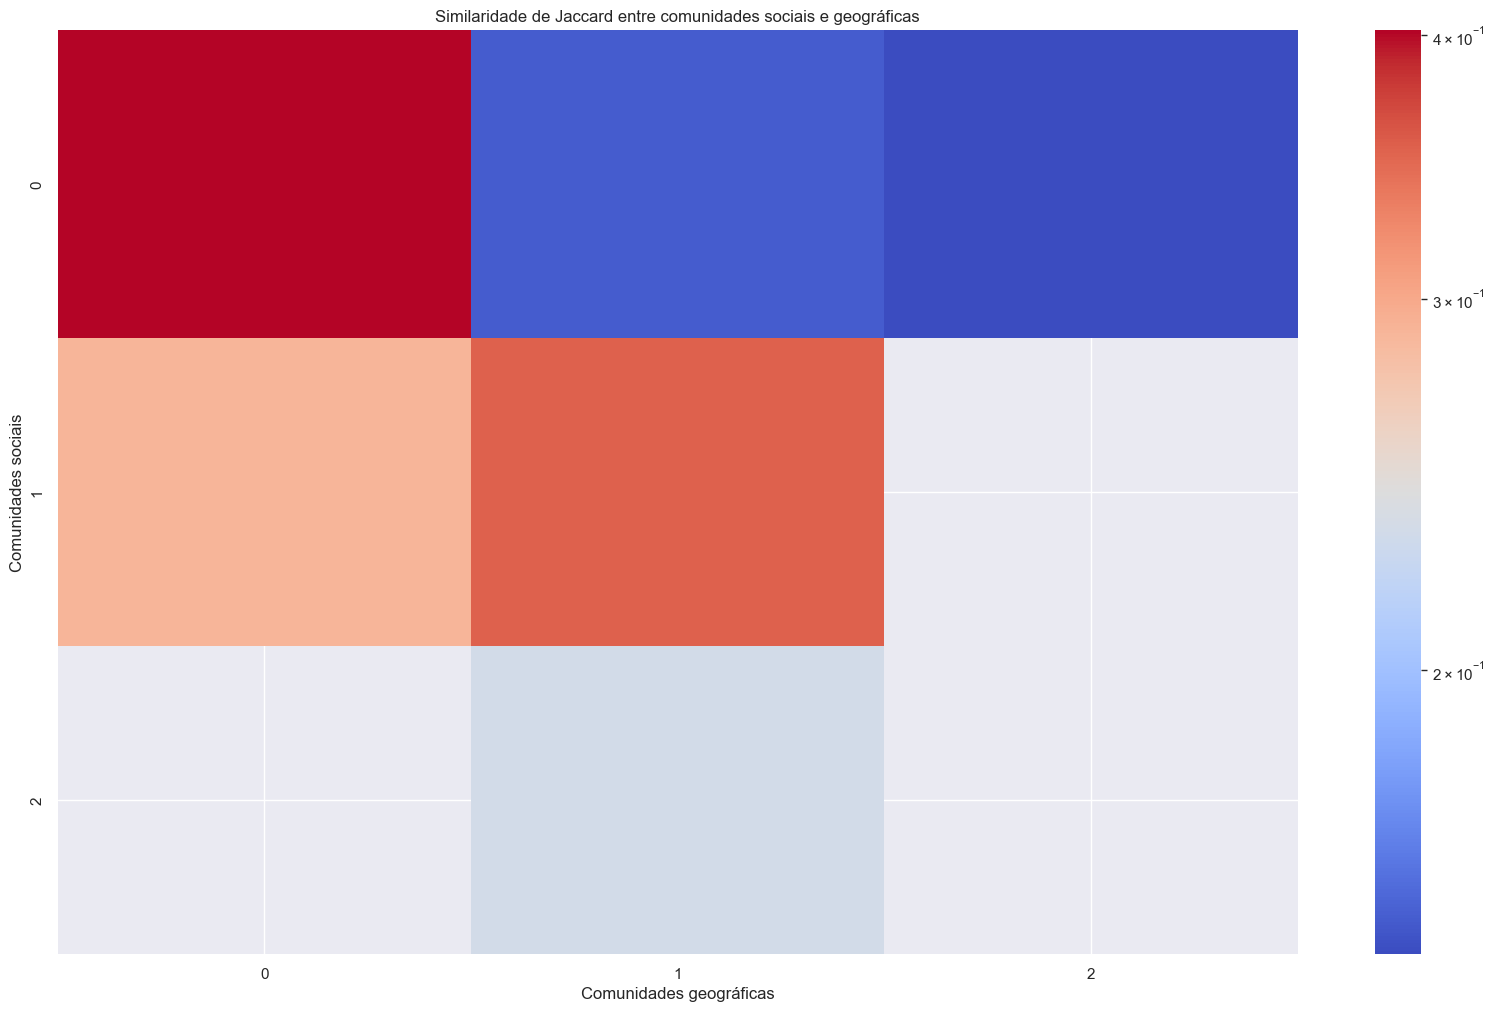

In [72]:
plt.figure(figsize=(20, 12))
sns.heatmap(permuted_matrix, cmap='coolwarm', norm=LogNorm())
plt.xlabel('Comunidades geográficas')
plt.ylabel('Comunidades sociais')
plt.title('Similaridade de Jaccard entre comunidades sociais e geográficas')
plt.show()

In [73]:
ami_jaccard_watts = ami(assign_labels(comunidade_social_watts, grafo.nodes()), assign_labels(comunidade_geo, grafo_geo.nodes()))
print(f"AMI: {ami_jaccard_watts}")

AMI: 0.21378478434101786
